In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary
from tqdm import tqdm
import os
import shutil


In [18]:
#RNN model for Residual echo suppression
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, fclayer_dim, output_dim, num_layers,dropout_prob):
        super().__init__()
        # Defining the number of layers and the nodes in each layer
        self.layer_dim=num_layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.LSTM(
            fclayer_dim, hidden_dim, num_layers, batch_first=True
        )
        self.tanh=nn.Tanh()
        self.fc1= nn.Linear(input_dim,fclayer_dim)
        self.fc2= nn.Linear(hidden_dim,output_dim)
        self.sig=nn.Sigmoid()


    def forward(self, x):
        
        y= self.fc1(x)

        y= self.tanh(y)
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, y.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(y)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out=self.tanh(out)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(out)
        out = self.sig(out)
        return out

In [19]:
model_path= "./pretrained/model/aec_lstm_0406174616.pth"
specdims=(512,64)
nfft_len=specdims[0]*2-1
model=LSTMNet(input_dim=specdims[0]*2, hidden_dim=25, fclayer_dim=25, output_dim=specdims[0], num_layers=1,dropout_prob=0.0)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Run a test file using the model to process and remove the echo

In [24]:
shutil.rmtree("../measure_erle/")
os.mkdir("../measure_erle/")
for i in tqdm(range(0,100)):
    file_indx=np.random.randint(3000,9000)
    file_indx=42
    mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
    fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    echo_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_"+str(file_indx)+".wav",sr=8000)
    mic_stft=librosa.stft(echo_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    fend_stft=librosa.stft(fend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    nend_stft=librosa.stft(nend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    fx=librosa.stft(fend_sig,n_fft=nfft_len,hop_length=nfft_len//4)
    res_spec=np.zeros((specdims[0],specdims[1]*(mic_stft.shape[1]//specdims[1])),dtype=np.complex64)
    for i in range(0,mic_stft.shape[1]//specdims[1]):
        mic=  mic_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        fend= fend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        nend= nend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        tmic = torch.tensor(abs(mic))
        tfend = torch.tensor(abs(fend))
        tnend = torch.tensor(abs(nend))
        y=torch.permute(tmic,(1,0))
        x=torch.concat((tmic,tfend),0)
        x= torch.permute(x,(1,0))
        x=x.unsqueeze(0)
        x=x.to(dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            out=model(x*x)
        out = out*y
        out=out.squeeze(0)
        out= torch.permute(out,(1,0))
        out=out.cpu().numpy()
        mag,ph=librosa.magphase(mic)
        out=out*ph
        #print(out.shape)
        res_spec[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out
        #specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec
    res_nend=librosa.istft(res_spec,hop_length=nfft_len//4,n_fft=nfft_len)
    #res_nend=librosa.util.normalize(res_nend)
    wav.write("../measure_erle/echo_cancelled_fileid_"+str(file_indx)+".wav", 8000, res_nend)
    wav.write("../measure_erle/mic_fileid_"+str(file_indx)+".wav", 8000, mic_sig)
    wav.write("../measure_erle/nend_fileid_"+str(file_indx)+".wav", 8000, nend_sig)
    wav.write("../measure_erle/fend_fileid_"+str(file_indx)+".wav", 8000, fend_sig)
    wav.write("../measure_erle/echo_fileid_"+str(file_indx)+".wav", 8000, echo_sig)

100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


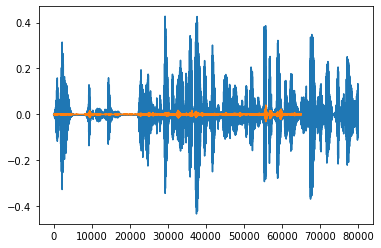

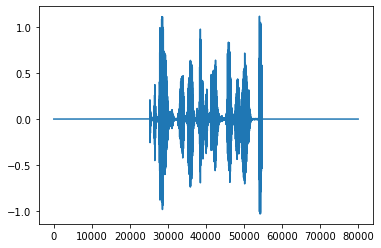

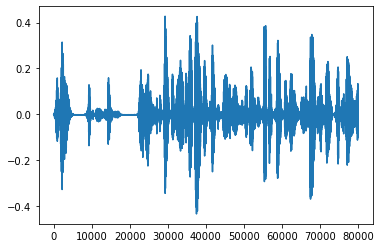

In [25]:
plt.figure()
plt.plot(echo_sig)
plt.plot(res_nend)
plt.figure()
plt.plot(nend_sig)
plt.figure()
plt.plot(echo_sig)


In [26]:
shutil.rmtree("../measure_sdr/")
os.mkdir("../measure_sdr/")
for i in tqdm(range(0,100)):
    file_indx=np.random.randint(3000,9000)
    mic_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_"+str(file_indx)+".wav",sr=8000)
    fend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    nend_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_"+str(file_indx)+".wav",sr=8000)
    echo_sig,_=librosa.load("../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_"+str(file_indx)+".wav",sr=8000)
    mic_stft=librosa.stft(mic_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    fend_stft=librosa.stft(fend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    nend_stft=librosa.stft(nend_sig,n_fft=nfft_len, hop_length=nfft_len//4,center=True)
    fx=librosa.stft(fend_sig,n_fft=nfft_len,hop_length=nfft_len//4)
    res_spec=np.zeros((specdims[0],specdims[1]*(mic_stft.shape[1]//specdims[1])),dtype=np.complex64)
    for i in range(0,mic_stft.shape[1]//specdims[1]):
        mic=  mic_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        fend= fend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        nend= nend_stft[:,specdims[1]*i:specdims[1]*i+specdims[1]]
        tmic = torch.tensor(abs(mic))
        tfend = torch.tensor(abs(fend))
        tnend = torch.tensor(abs(nend))
        y=torch.permute(tmic,(1,0))
        x=torch.concat((tmic,tfend),0)
        x= torch.permute(x,(1,0))
        x=x.unsqueeze(0)
        x=x.to(dtype=torch.float32)
        model.eval()
        with torch.no_grad():
            out=model(x*x)
        out = out*y
        out=out.squeeze(0)
        out= torch.permute(out,(1,0))
        out=out.cpu().numpy()
        mag,ph=librosa.magphase(mic)
        out=out*ph
        #print(out.shape)
        res_spec[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out
        #specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec
    res_nend=librosa.istft(res_spec,hop_length=nfft_len//4,n_fft=nfft_len)
    #res_nend=librosa.util.normalize(res_nend)
    wav.write("../measure_sdr/echo_cancelled_fileid_"+str(file_indx)+".wav", 8000, res_nend)
    wav.write("../measure_sdr/mic_fileid_"+str(file_indx)+".wav", 8000, mic_sig)
    wav.write("../measure_sdr/nend_fileid_"+str(file_indx)+".wav", 8000, nend_sig)
    wav.write("../measure_sdr/fend_fileid_"+str(file_indx)+".wav", 8000, fend_sig)
    wav.write("../measure_sdr/echo_fileid_"+str(file_indx)+".wav", 8000, echo_sig)

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


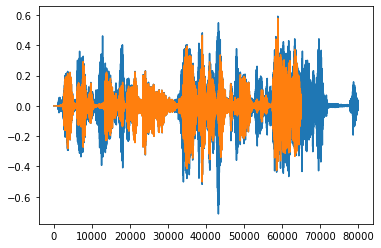

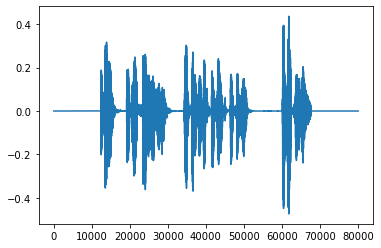

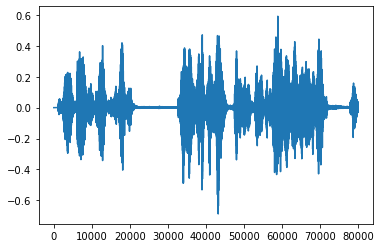

In [27]:
plt.figure()
plt.plot(mic_sig)
plt.plot(res_nend)
plt.figure()
plt.plot(nend_sig)
plt.figure()
plt.plot(echo_sig)